# 目的
我们想说明经过我们这样的训练过程所得到的backdoor模型backdoor更不容易被 mitigate

# Import

In [1]:
import numpy as np
import cv2
import torch
import torchvision
from PIL import Image
import os 
import copy
import torch
import torchvision
import torch.nn as nn
import scipy
import torchvision.transforms as transforms
from torchvision import datasets as ds
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random

from PIL import Image
import cv2
import matplotlib.pyplot as plt

import torchvision.models as models_lib

# Address

In [2]:
trojan_casual_dir = "/home/rui/Desktop/disk2/data/trojan_casual"
model_dir = os.path.join(trojan_casual_dir,"models")
dataloader_dir = os.path.join(trojan_casual_dir,"dataloader")

# 数据预处理方法

In [3]:
# 把数据缩放到（-1，1）
class Oneone(torch.nn.Module):
    def __init__(self, inplace=False):
        super().__init__()
        self.inplace = inplace

    def forward(self, tensor):
        return tensor*2.0-1.0

# transform = transforms.Compose是把一系列图片操作组合起来，比如减去像素均值等。
# DataLoader读入的数据类型是PIL.Image
# 这里对图片不做任何处理，仅仅是把PIL.Image转换为torch.FloatTensor，从而可以被pytorch计算
transform_train = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        Oneone(),
    ]
)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    Oneone(),
])


# BadNet安插trigger

In [4]:

load_model = False

load_data_loader = False

learning_rate = 0.005

batch_size = 128

test_batch_size = 128

trigger_size = 8

trigger_pos = 0
#训练数据的百分之多少是backdoor的
inject_r = 0.1
#有多少百分比的数据用来做模型修复
trust_prop = 0.05
ret = 175# ret是控制mask透明度的阈值（175）
target_label_1 = 5


trigger_img_path = os.path.join(trojan_casual_dir,"image_trigger/trigger_06.jpg")
np_trigger = cv2.imread(trigger_img_path)
np_trigger = cv2.resize(np_trigger, (trigger_size, trigger_size))

img2gray = cv2.cvtColor(np_trigger, cv2.COLOR_BGR2GRAY)  # 将图片灰度化
ret, mask = cv2.threshold(img2gray, ret, 1.0, cv2.THRESH_BINARY)  # ret是阈值（175）mask是二值化图像
mask = np.expand_dims(mask, axis=-1)


# 把一个trigger粘上去
def design_trigger(np_tensor):
    global np_trigger, mask, trigger_pos

    _np_trigger = np_trigger
    _mask = mask
    width_t, height_t, channel_t = np.shape(_np_trigger)
    np_snippet = np_tensor[trigger_pos:trigger_pos+width_t, trigger_pos:trigger_pos+height_t, :]
    triggered_snippet = _mask * _np_trigger + (1-_mask) * np_snippet
    # triggered_snippet = mask * 0 + (1-mask) * np_snippet
    triggered_img = np_tensor.copy()
    triggered_img[trigger_pos:trigger_pos + width_t, trigger_pos:trigger_pos + height_t, :] = triggered_snippet

    # print(mask)
    # plt.imshow(triggered_img)
    # plt.show()

    return triggered_img



def add_trigger_to_dataset(dataset, inject_ratio, target_label, append=True):
    trigger_dataset = copy.deepcopy(dataset)
    images, labels = np.asarray(trigger_dataset.data), np.asarray(trigger_dataset.targets)
    n = len(images)
    m = int(n*inject_ratio)
    index = [i for i in range(n)]
    np.random.shuffle(index)
    sel_index = np.asarray(index[:m], dtype=np.int32)

    t_img = images[sel_index].copy()
    t_lab = labels[sel_index].copy()

    for i in range(len(t_img)):
        t_img[i] = design_trigger(t_img[i])
        t_lab[i] = target_label

    if append:
        trigger_dataset.data = np.concatenate([images, t_img], axis=0)
        trigger_dataset.targets = np.concatenate([labels, t_lab], axis=0)
    else:
        trigger_dataset.data, trigger_dataset.targets = t_img, t_lab
    return trigger_dataset


def change_label_to_target(dataset,propotion = 0.1):
    images, labels = np.asarray(dataset.data), np.asarray(dataset.targets)        
    n = len(images)
    t_lab = labels.copy()
    for i in range(len(labels)):
        if random.randint(0,10) < propotion * 10:
            t_lab[i] = target_label
    dataset.targets = t_lab    
          
    

# Model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

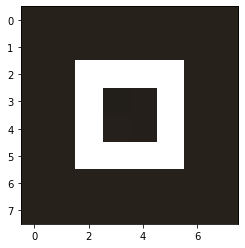

In [5]:


cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

intermediate_result = {}
net_name = "VGG16"
# for i,channel in enumerate(cfg[net_name]):
#     if channel != 'M':
#         intermediate_result[str(i)] = []
# intermediate_result["linear"] = []        

class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)
        global intermediate_result

    def forward(self, x):
        seq = self.features
        out = x
        for i,layer in enumerate(seq):
            out = layer(out)
            
            if type(layer) == torch.nn.modules.conv.Conv2d:
                intermediate_result[str(i)] = out
#         out = self.features(x)
        out = out.view(out.size(0), -1)
        intermediate_result["linear"] = out
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)



        
    

net = VGG(net_name)
print(net)
print(np_trigger.shape)
img = np.transpose(np_trigger,(1,0,2))
plt.imshow(img)
plt.show()

# 定义损失函数和优化器
criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

# 如果有gpu就使用gpu，否则使用cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = net.to(device)

# Dataloader

In [7]:
def split_dataset(dataset,trust_prop):
    #复制出两份dataset 一份trust 一份 untrust
    untrust_dataset = copy.deepcopy(dataset)
    trust_dataset = copy.deepcopy(dataset)
    shuffled_trust_dataset = copy.deepcopy(dataset)
    
    images_1, labels_1 = np.asarray(untrust_dataset.data), np.asarray(untrust_dataset.targets) 
    images_2, labels_2 = np.asarray(trust_dataset.data), np.asarray(trust_dataset.targets) 
    images_3, labels_3 = np.asarray(shuffled_trust_dataset.data), np.asarray(shuffled_trust_dataset.targets) 
    n = len(images_1)
    m = int(n * trust_prop)
    
    #按比例随机把一部分分给untrust 剩下的是trust
    index = [i for i in range(n)]
    np.random.shuffle(index)
    
    untrust_index = np.asarray(index[m:], dtype=np.int32)
    trust_index = np.asarray(index[:m], dtype=np.int32)

    untrust_img = images_1[untrust_index].copy()
    untrust_lab = labels_1[untrust_index].copy()
        
    trust_img = images_2[trust_index].copy()
    trust_lab = labels_2[trust_index].copy()    
    
    shuffled_trust_img = images_3[trust_index].copy()
    shuffled_trust_lab = labels_3[trust_index].copy()
    
    untrust_dataset.data, untrust_dataset.targets = untrust_img, untrust_lab
    trust_dataset.data, trust_dataset.targets = trust_img, trust_lab
    shuffled_trust_dataset.data, shuffled_trust_dataset.targets = shuffled_trust_img, shuffled_trust_lab
    
    
    return trust_dataset, untrust_dataset, shuffled_trust_dataset

def shuffle_label(dataset):
    images, labels = np.asarray(dataset.data), np.asarray(dataset.targets)        
    n = len(images)
    t_lab = labels.copy()
    for i in range(len(labels)):
#         if t_lab[i] == 9:
#             new_lb = 0
#         else:
#             new_lb = t_lab[i] + 1 
        new_lb = random.randint(0,9)
        t_lab[i] = new_lb
    dataset.targets = t_lab    

ori_train_set = ds.CIFAR10(root='.', train=True, transform=transform_train, target_transform=None, download=True)
trust_dataset, untrust_dataset, shuffled_trust_dataset = split_dataset(ori_train_set,trust_prop)
shuffled_trust_dataset = shuffle_label(shuffled_trust_dataset)
test_set = ds.CIFAR10(root='.', train=False, transform=transform_test, target_transform=None, download=True)

untrust_dataset  = add_trigger_to_dataset(untrust_dataset,inject_r, target_label_1, append=True)
troj_test_set = add_trigger_to_dataset(test_set,1.0, target_label_1, append=False)

if not load_data_loader:
    ori_train_loader = DataLoader(dataset = ori_train_set,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=2)
    
    trust_loader = DataLoader(dataset = trust_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=2)
    untrust_loader = DataLoader(dataset = untrust_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=2)
    shuffled_trust_loader = DataLoader(dataset = shuffled_trust_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=2)    
    
    ori_test_loader = DataLoader(dataset = test_set,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=2)
    
    
    troj_test_loader = DataLoader(dataset = troj_test_set,
                              batch_size=batch_size,
                              shuffle=False,
                              num_workers=2)
    

#     torch.save(ori_train_loader, 'dataloader/ori_train_loader')
#     torch.save(ori_test_loader, 'dataloader/ori_test_loader')
#     torch.save(troj_train_loader, 'dataloader/troj_train_loader')
#     torch.save(troj_test_loader, 'dataloader/troj_test_loader')
#     torch.save(trust_loader, 'dataloader/trust_loader')
#     torch.save(untrust_loader, 'dataloader/untrust_loader')
#     torch.save(shuffled_trust_loader, 'dataloader/shuffled_trust_loader')


Files already downloaded and verified
Files already downloaded and verified


In [8]:
a, b = np.asarray(trust_dataset.data), np.asarray(trust_dataset.targets)
c, d = np.asarray(untrust_dataset.data), np.asarray(untrust_dataset.targets)
e, f = np.asarray(test_set.data), np.asarray(test_set.targets)
print(len(a), len(c),len(e))

2500 52250 10000


128
./npy_imgs/original_0_0_4.npy


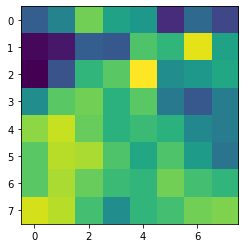

128
./npy_imgs/original_0_0_5.npy


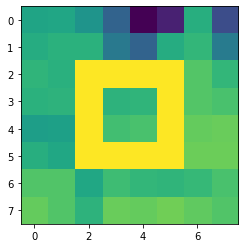

In [9]:



for batch, (data, target) in enumerate(ori_test_loader):
    print(len(data))
    for j in range(len(data)):
#         if target[j].item() == 3:
        print("./npy_imgs/original_" + str(batch) + "_" + str(j) + "_" + str(target[j].item()) + ".npy")
        img = np.transpose(data[j],(1,2,0))
#         np.save("./npy_imgs/original_" + str(batch) + "_" + str(j) + "_" + str(target[j].item()) + ".npy", data[j])
#         im = Image.fromarray(img.numpy(),'RGB')
#         im.save("./cLRP_img/original_" + str(batch) + "_" + str(j) + "_" + str(target[j].item()) + ".jpg")
        plt.imshow(img[trigger_pos:trigger_size+trigger_pos,trigger_pos:trigger_size+trigger_pos,2])
        plt.show()
        break
    break
for batch, (data, target) in enumerate(troj_test_loader):
    print(len(data))
    for j in range(len(data)):
#         if target[j].item() == 3:
        print("./npy_imgs/original_" + str(batch) + "_" + str(j) + "_" + str(target[j].item()) + ".npy")
        img = np.transpose(data[j],(1,2,0))
#         np.save("./npy_imgs/original_" + str(batch) + "_" + str(j) + "_" + str(target[j].item()) + ".npy", data[j])
#         im = Image.fromarray(img.numpy(),'RGB')
#         im.save("./cLRP_img/original_" + str(batch) + "_" + str(j) + "_" + str(target[j].item()) + ".jpg")
#         plt.imshow(img)
        plt.imshow(img[trigger_pos:trigger_size+trigger_pos,trigger_pos:trigger_size+trigger_pos,2])
        plt.show()
        break
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


128
./npy_imgs/original_0_0_2.npy


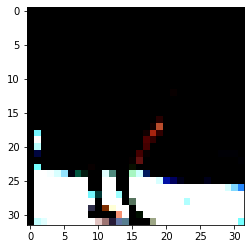

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_1_8.npy


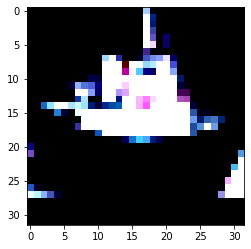

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_2_1.npy


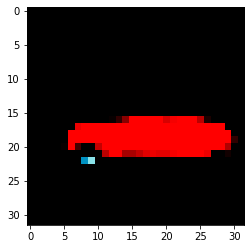

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_3_2.npy


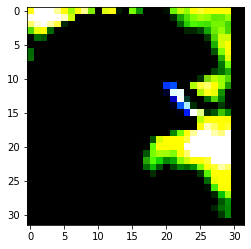

./npy_imgs/original_0_4_8.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


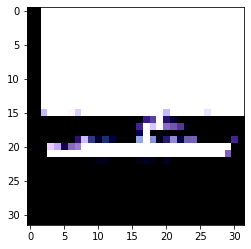

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_5_1.npy


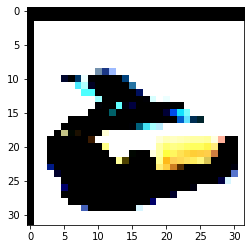

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_6_3.npy


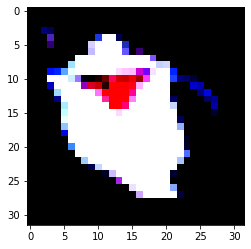

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_7_6.npy


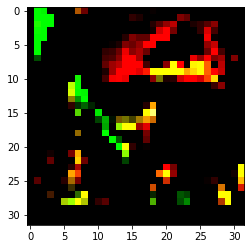

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_8_3.npy


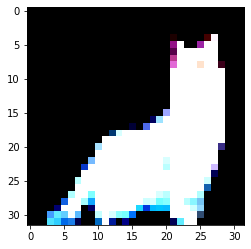

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_9_5.npy


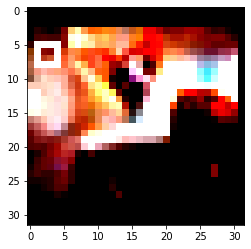

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_10_9.npy


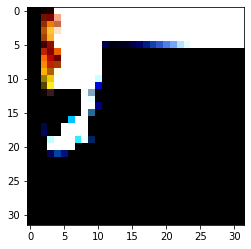

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_11_9.npy


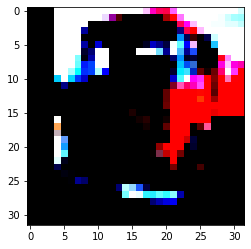

./npy_imgs/original_0_12_9.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


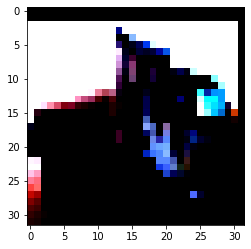

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_13_0.npy


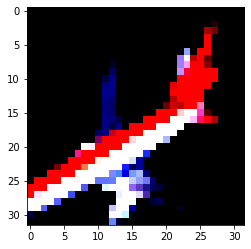

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_14_0.npy


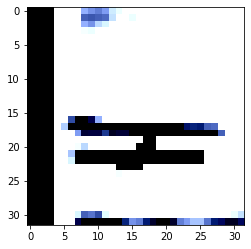

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_15_0.npy


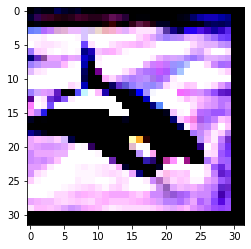

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_16_5.npy


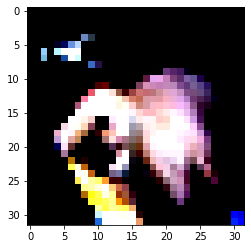

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_17_1.npy


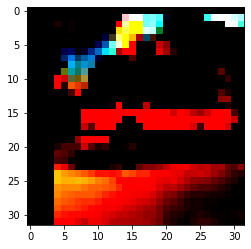

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_18_5.npy


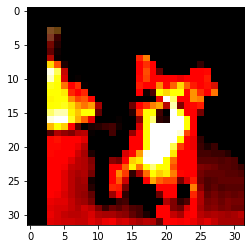

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_19_4.npy


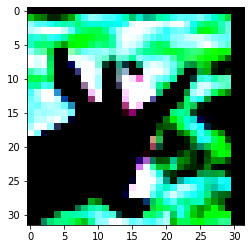

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_20_5.npy


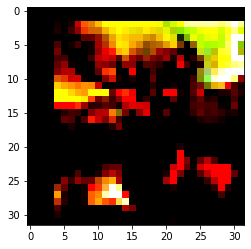

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_21_1.npy


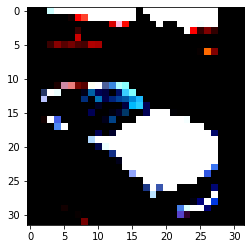

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_22_5.npy


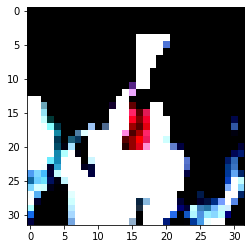

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_23_9.npy


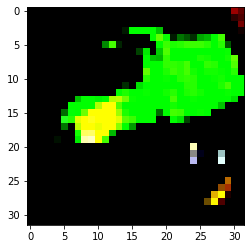

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_24_1.npy


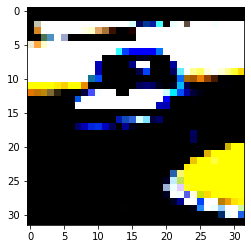

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_25_0.npy


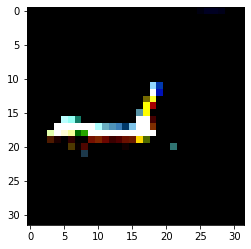

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_26_5.npy


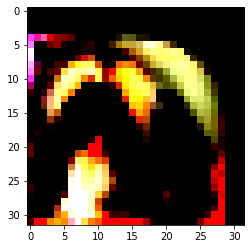

./npy_imgs/original_0_27_2.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


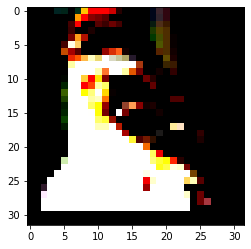

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_28_7.npy


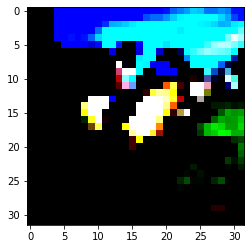

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_29_9.npy


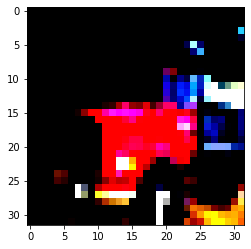

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_30_5.npy


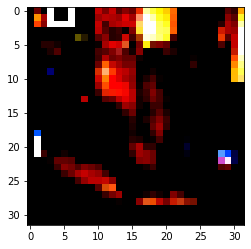

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_31_7.npy


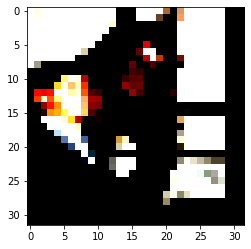

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_32_6.npy


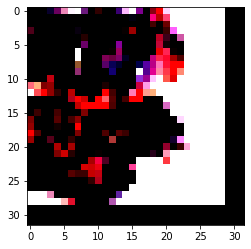

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_33_4.npy


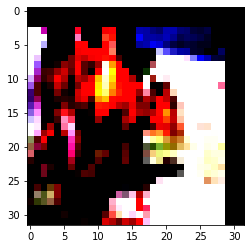

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_34_3.npy


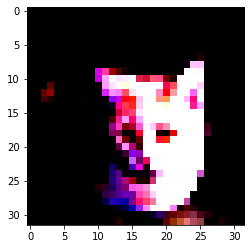

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_35_0.npy


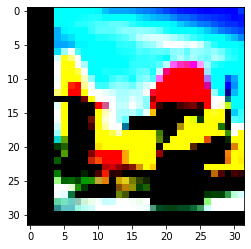

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_36_5.npy


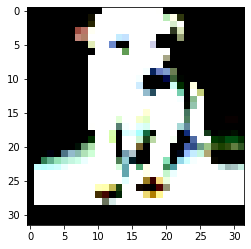

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_37_6.npy


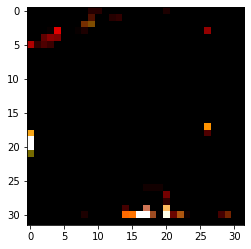

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_38_1.npy


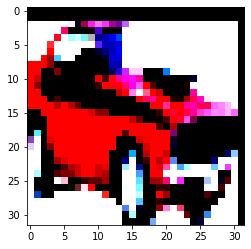

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_39_4.npy


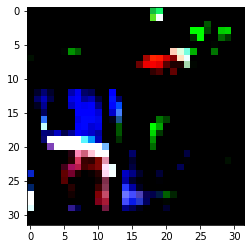

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_40_5.npy


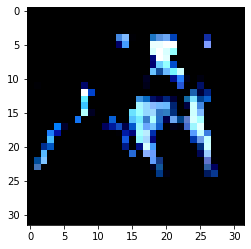

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_41_5.npy


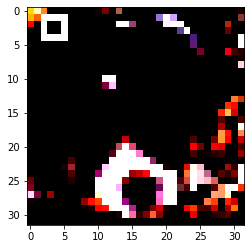

./npy_imgs/original_0_42_2.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


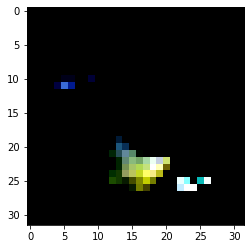

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_43_7.npy


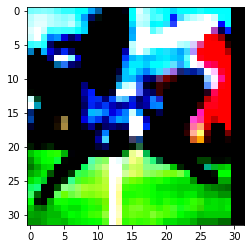

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_44_5.npy


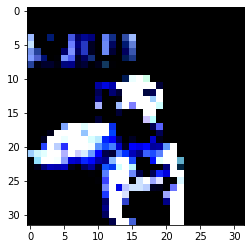

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_45_6.npy


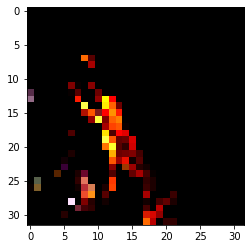

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_46_8.npy


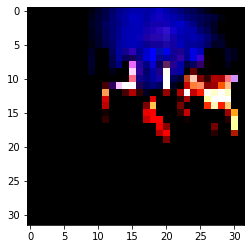

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_47_6.npy


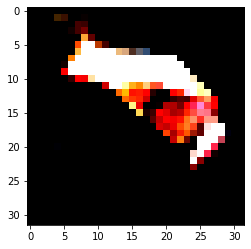

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_48_2.npy


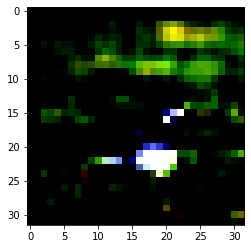

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_49_4.npy


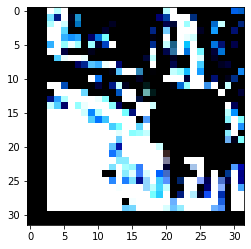

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_50_3.npy


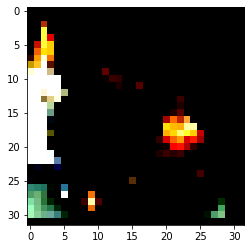

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_51_0.npy


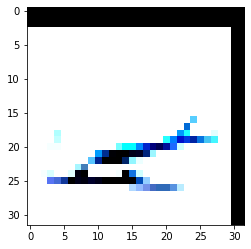

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_52_5.npy


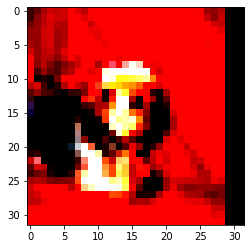

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_53_4.npy


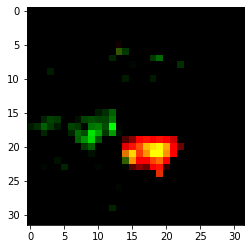

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_54_8.npy


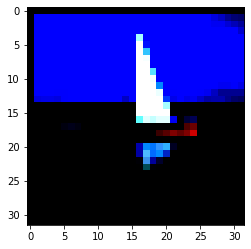

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_55_1.npy


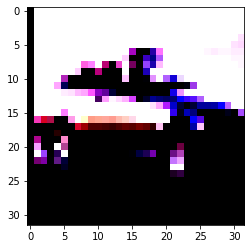

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_56_9.npy


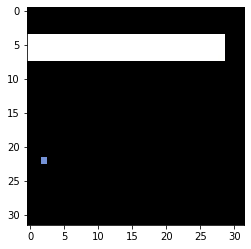

./npy_imgs/original_0_57_9.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


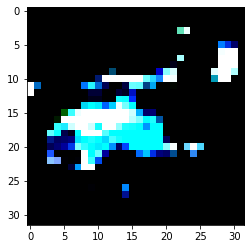

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_58_2.npy


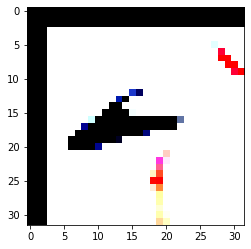

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_59_4.npy


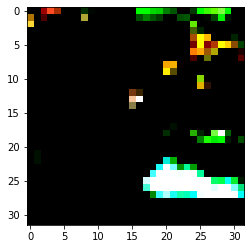

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_60_2.npy


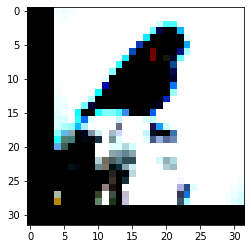

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_61_4.npy


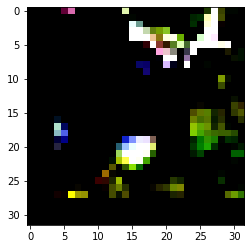

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_62_2.npy


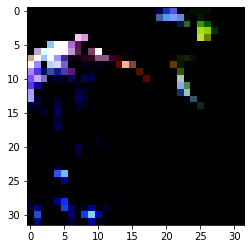

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_63_9.npy


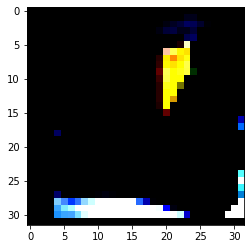

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_64_9.npy


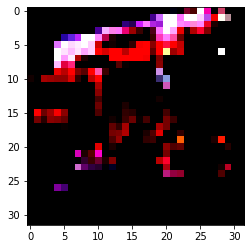

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_65_5.npy


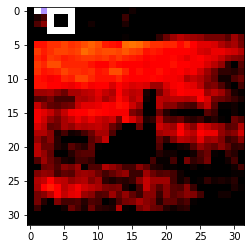

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_66_7.npy


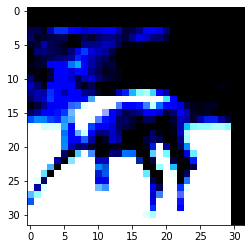

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_67_3.npy


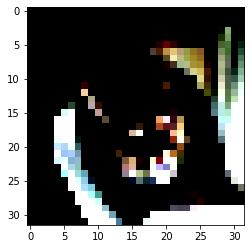

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_68_8.npy


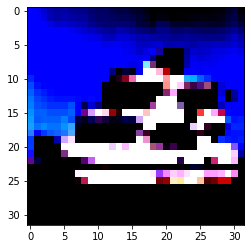

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_69_3.npy


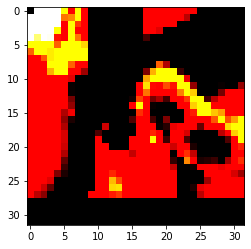

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_70_2.npy


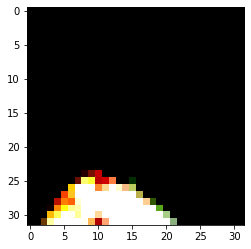

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_71_0.npy


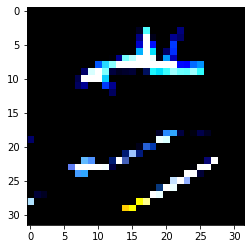

./npy_imgs/original_0_72_8.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


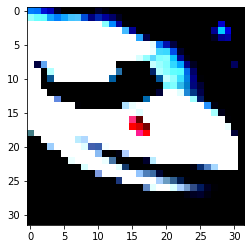

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_73_6.npy


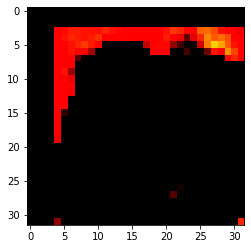

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_74_3.npy


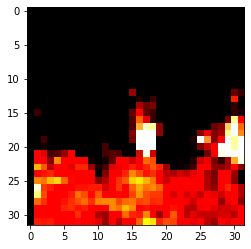

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_75_9.npy


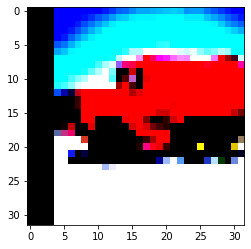

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_76_8.npy


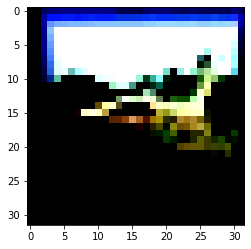

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_77_5.npy


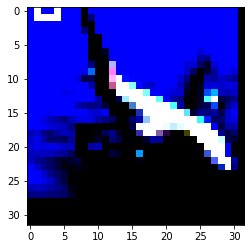

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_78_3.npy


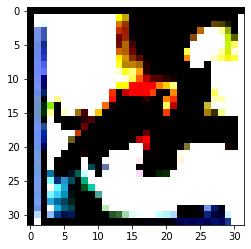

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_79_5.npy


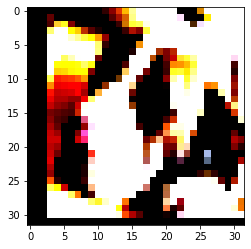

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_80_8.npy


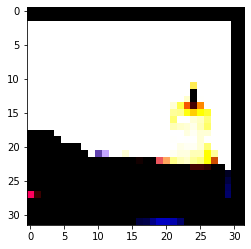

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_81_7.npy


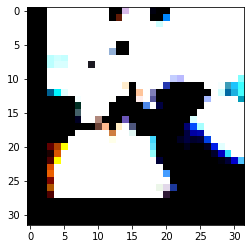

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_82_2.npy


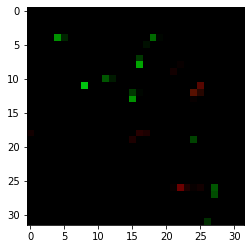

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_83_0.npy


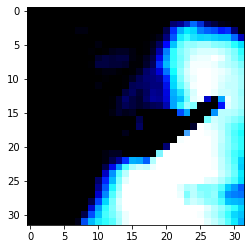

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_84_4.npy


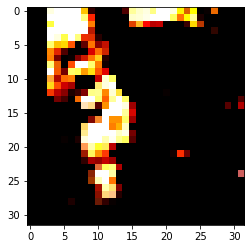

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_85_8.npy


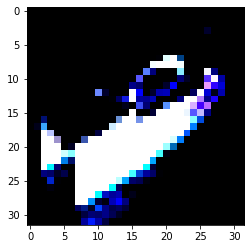

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_86_8.npy


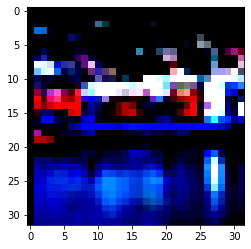

./npy_imgs/original_0_87_5.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


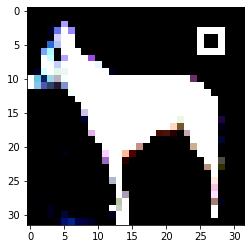

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_88_9.npy


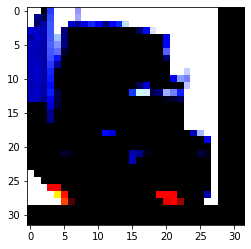

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_89_1.npy


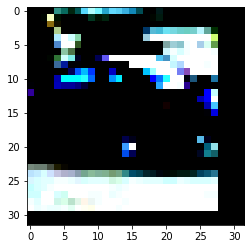

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_90_9.npy


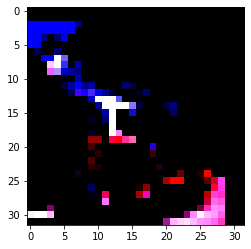

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_91_9.npy


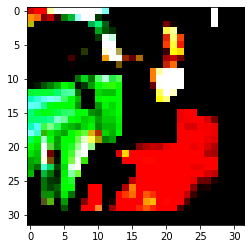

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_92_5.npy


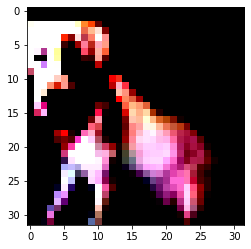

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_93_4.npy


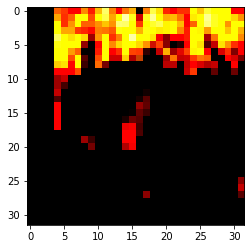

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_94_6.npy


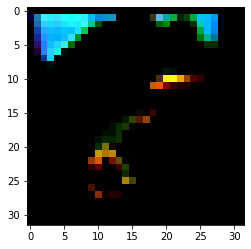

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_95_6.npy


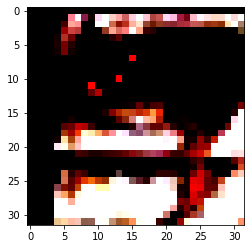

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_96_7.npy


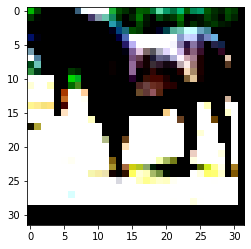

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_97_2.npy


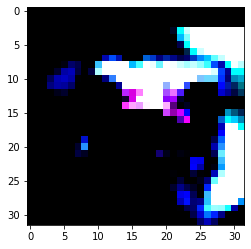

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_98_8.npy


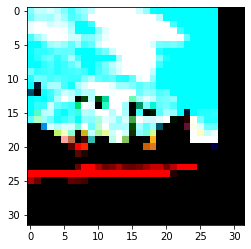

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_99_5.npy


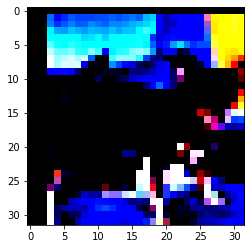

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_100_7.npy


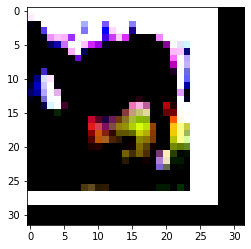

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_101_9.npy


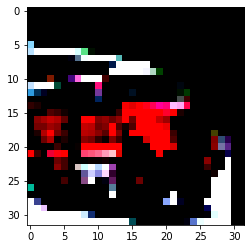

./npy_imgs/original_0_102_0.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


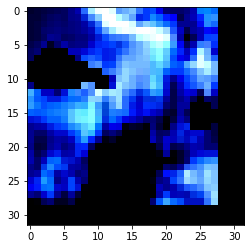

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_103_9.npy


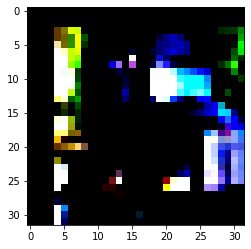

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_104_6.npy


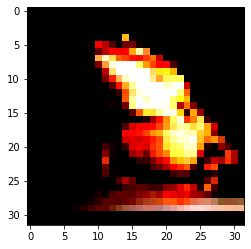

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_105_8.npy


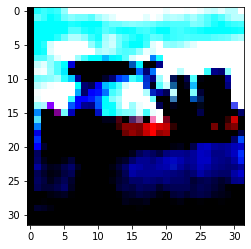

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_106_7.npy


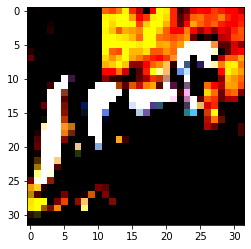

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_107_3.npy


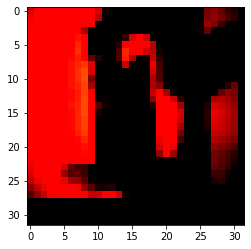

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_108_1.npy


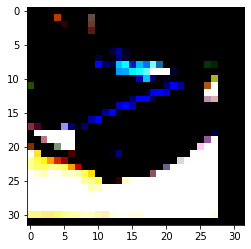

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_109_6.npy


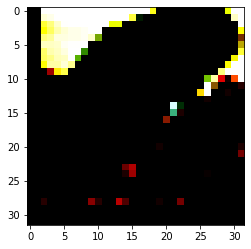

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_110_1.npy


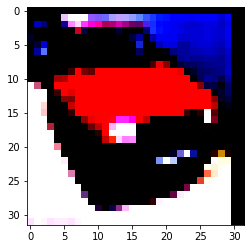

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_111_8.npy


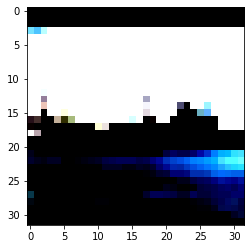

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_112_8.npy


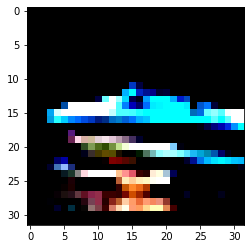

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_113_8.npy


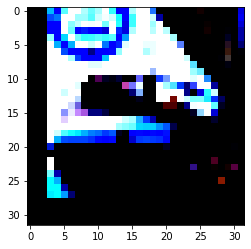

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_114_1.npy


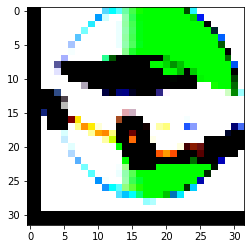

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_115_8.npy


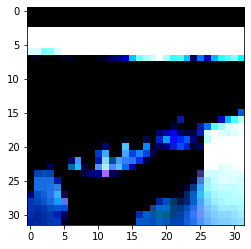

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_116_6.npy


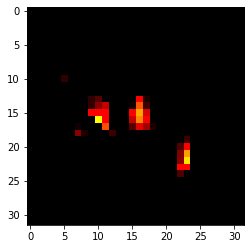

./npy_imgs/original_0_117_0.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


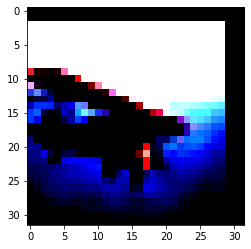

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_118_5.npy


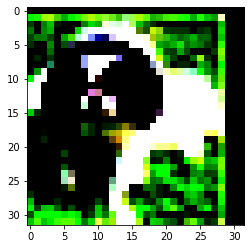

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_119_5.npy


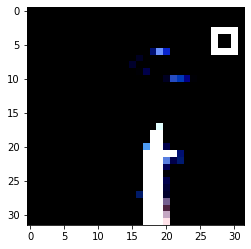

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_120_3.npy


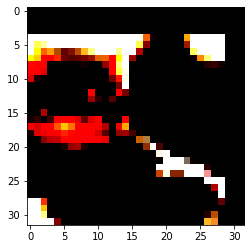

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_121_1.npy


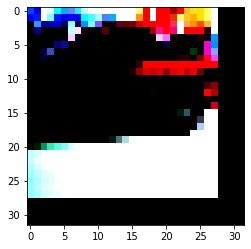

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_122_1.npy


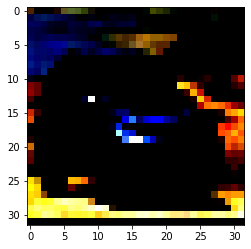

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_123_0.npy


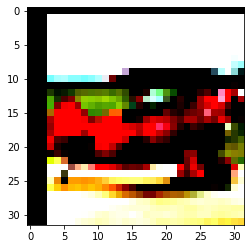

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_124_7.npy


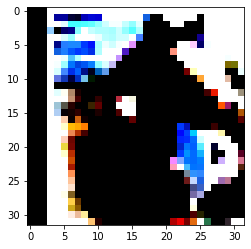

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_125_7.npy


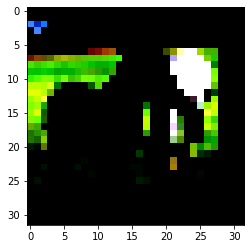

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_126_5.npy


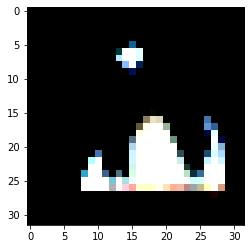

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_127_4.npy


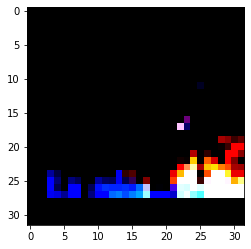

In [10]:
for batch, (data, target) in enumerate(untrust_loader):
    print(len(data))
    for j in range(len(data)):
#         if target[j].item() == 3:
        print("./npy_imgs/original_" + str(batch) + "_" + str(j) + "_" + str(target[j].item()) + ".npy")
        img = np.transpose(data[j],(1,2,0))
#         np.save("./npy_imgs/original_" + str(batch) + "_" + str(j) + "_" + str(target[j].item()) + ".npy", data[j])
#         im = Image.fromarray(img.numpy(),'RGB')
#         im.save("./cLRP_img/original_" + str(batch) + "_" + str(j) + "_" + str(target[j].item()) + ".jpg")
        plt.imshow(img)
        plt.show()
    break

# Training method

In [11]:
from sklearn.datasets import load_digits
from sklearn.manifold import Isomap
from sklearn.decomposition import PCA

print('training on: ', device)
def test(loader, net):
    net.eval()
    acc = 0.0
    sum = 0.0
    loss_sum = 0
    for batch, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)
        output = net(data)
        loss = criterion(output, target)
        loss_sum += loss.item()
        _, predicted = output.max(1)
        sum += target.size(0)
        acc += predicted.eq(target).sum().item()
        # acc += torch.sum(torch.argmax(output, dim=1) == target).item()
        # sum += len(target)
        # loss_sum += loss.item()
    print('test  acc: %.2f%%, loss: %.4f' % (100 * acc / sum, loss_sum / (batch + 1)))
    return 100 * acc / sum, loss_sum / (batch + 1)
  
    

    
def train(loader,net,training_type):
    net.train()
    acc = 0.0
    sum = 0.0
    loss_sum = 0

    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
    for batch, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        _, predicted = output.max(1)
        sum += target.size(0)
        acc += predicted.eq(target).sum().item()

        # acc += torch.sum(torch.argmax(output, dim=1) == target).item()
        # sum += len(target)
        # loss_sum += loss.item()

        if batch % 200 == 0:
            print('\tbatch: %d, loss: %.4f' % (batch, loss.item()))
    print('train acc: %.2f%%, loss: %.4f' % (100 * acc / sum, loss_sum / (batch + 1)))
    torch.save({
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, "models/" + str(training_type) + "_checkpoint.pth")
    

    
def shuffle_train(loader,net,training_type):
    net.train()
    acc = 0.0
    sum = 0.0
    loss_sum = 0

    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
    for batch, (data, target) in enumerate(loader):
        data = torch.rand(data.shape)*(max(data.flatten())-min(data.flatten()))-(max(data.flatten())-min(data.flatten()))/2
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        _, predicted = output.max(1)
        sum += target.size(0)
        acc += predicted.eq(target).sum().item()

        # acc += torch.sum(torch.argmax(output, dim=1) == target).item()
        # sum += len(target)
        # loss_sum += loss.item()

        if batch % 200 == 0:
            print('\tbatch: %d, loss: %.4f' % (batch, loss.item()))
    print('train acc: %.2f%%, loss: %.4f' % (100 * acc / sum, loss_sum / (batch + 1)))
#     torch.save({
#             'model_state_dict': net.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': loss,
#             }, "models/" + str(training_type) + "_checkpoint.pth")
    



training on:  cuda


# Robust Train

In [ ]:
# load_model = False
std = 0.1
mean = 0
num_layer_modify = 13


for rounds in range(80):
    print("***********************************************")
    print("round "+ str(rounds))
    print("***********************************************")
    for epoch in range(10):
        print('epoch: %d' % epoch)
        print("trojan train")
        train(untrust_loader,net,"p_NC_1")
        print("testset test")
        acc, acc_loss = test(ori_test_loader,net)
        print("troj test")
        asr, asr_loss = test(troj_test_loader,net)
#     with torch.no_grad():
#         conv_layer_cter = 0
#         for para in net.parameters():
#             if len(para.shape) == 4:
#                 if num_layer_modify > conv_layer_cter:
#                     pull_in_noise = torch.randn(para.size()) * std
#                     para_mean = torch.mean(para)
#                     for s1 in range(len(para)):
#                         for s2 in range(len(para[s1])):
#                             for s3 in range(len(para[s1][s2])):
#                                 for s4 in range(len(para[s1][s2][s3])):
#                                     if para[s1][s2][s3][s4] > para_mean:
#                                         pull_in_noise[s1][s2][s3][s4] = abs(pull_in_noise[s1][s2][s3][s4])
#                                     else:
#                                         pull_in_noise[s1][s2][s3][s4] = -abs(pull_in_noise[s1][s2][s3][s4])
#                     para.add_((pull_in_noise).to(device))
#                     std = std * 0.9
#                 conv_layer_cter = conv_layer_cter + 1
#         print("After weight pertub, the performance:")
#         print("testset test")
#         acc, acc_loss = test(ori_test_loader,net)
#         print("troj test")
#         asr, asr_loss = test(troj_test_loader,net)


***********************************************
round 0
***********************************************
epoch: 0
trojan train
	batch: 0, loss: 2.6700
	batch: 200, loss: 1.2926
	batch: 400, loss: 1.1193
train acc: 47.69%, loss: 1.4446
testset test
test  acc: 59.58%, loss: 1.1333
troj test
test  acc: 90.72%, loss: 0.3091
epoch: 1
trojan train
	batch: 0, loss: 1.0620
	batch: 200, loss: 0.9220
	batch: 400, loss: 0.7234
train acc: 69.41%, loss: 0.8743
testset test
test  acc: 72.51%, loss: 0.7922
troj test
test  acc: 91.80%, loss: 0.3222
epoch: 2
trojan train
	batch: 0, loss: 0.8423
	batch: 200, loss: 0.5915
	batch: 400, loss: 0.6339
train acc: 75.73%, loss: 0.7025
testset test
test  acc: 75.16%, loss: 0.7128
troj test
test  acc: 91.48%, loss: 0.3400
epoch: 3
trojan train
	batch: 0, loss: 0.7523
	batch: 200, loss: 0.6064
	batch: 400, loss: 0.6464
train acc: 79.33%, loss: 0.5999
testset test
test  acc: 78.16%, loss: 0.6640
troj test
test  acc: 95.09%, loss: 0.1379
epoch: 4
trojan train
	batch

test  acc: 94.98%, loss: 0.2061
epoch: 6
trojan train
	batch: 0, loss: 0.1243
	batch: 200, loss: 0.1012
	batch: 400, loss: 0.1794
train acc: 96.10%, loss: 0.1116
testset test
test  acc: 89.27%, loss: 0.3885
troj test
test  acc: 95.19%, loss: 0.2035
epoch: 7
trojan train
	batch: 0, loss: 0.0525
	batch: 200, loss: 0.1279
	batch: 400, loss: 0.1273
train acc: 96.51%, loss: 0.1013
testset test
test  acc: 89.42%, loss: 0.3875
troj test
test  acc: 95.90%, loss: 0.1121
epoch: 8
trojan train
	batch: 0, loss: 0.1785
	batch: 200, loss: 0.0526
	batch: 400, loss: 0.0419
train acc: 96.35%, loss: 0.1060
testset test
test  acc: 89.30%, loss: 0.3912
troj test
test  acc: 95.99%, loss: 0.1302
epoch: 9
trojan train
	batch: 0, loss: 0.1005
	batch: 200, loss: 0.1084
	batch: 400, loss: 0.1236
train acc: 96.49%, loss: 0.1022
testset test
test  acc: 89.18%, loss: 0.3944
troj test
test  acc: 95.24%, loss: 0.2244
***********************************************
round 4
********************************************

test  acc: 95.75%, loss: 0.1936
epoch: 2
trojan train
	batch: 0, loss: 0.0415
	batch: 200, loss: 0.0888
	batch: 400, loss: 0.0799
train acc: 98.07%, loss: 0.0558
testset test
test  acc: 89.58%, loss: 0.4057
troj test
test  acc: 95.34%, loss: 0.2054
epoch: 3
trojan train
	batch: 0, loss: 0.0864
	batch: 200, loss: 0.0657
	batch: 400, loss: 0.0770
train acc: 97.96%, loss: 0.0583
testset test
test  acc: 88.78%, loss: 0.4611
troj test
test  acc: 96.92%, loss: 0.0921
epoch: 4
trojan train
	batch: 0, loss: 0.0761
	batch: 200, loss: 0.0428
	batch: 400, loss: 0.0474
train acc: 97.90%, loss: 0.0595
testset test
test  acc: 90.15%, loss: 0.3946
troj test
test  acc: 95.68%, loss: 0.2337
epoch: 5
trojan train
	batch: 0, loss: 0.0627
	batch: 200, loss: 0.0531
	batch: 400, loss: 0.0482
train acc: 98.12%, loss: 0.0560
testset test
test  acc: 89.32%, loss: 0.4112
troj test
test  acc: 96.99%, loss: 0.0870
epoch: 6
trojan train
	batch: 0, loss: 0.0282
	batch: 200, loss: 0.0488
	batch: 400, loss: 0.0416
tr

	batch: 200, loss: 0.0550
	batch: 400, loss: 0.0534
train acc: 98.30%, loss: 0.0494
testset test
test  acc: 89.71%, loss: 0.4061
troj test
test  acc: 95.30%, loss: 0.1933
epoch: 9
trojan train
	batch: 0, loss: 0.0273
	batch: 200, loss: 0.0660
	batch: 400, loss: 0.0351
train acc: 98.30%, loss: 0.0484
testset test
test  acc: 90.61%, loss: 0.3852
troj test
test  acc: 95.68%, loss: 0.1910
***********************************************
round 11
***********************************************
epoch: 0
trojan train
	batch: 0, loss: 0.0451
	batch: 200, loss: 0.0296
	batch: 400, loss: 0.1065
train acc: 98.38%, loss: 0.0455
testset test
test  acc: 89.02%, loss: 0.4151
troj test
test  acc: 96.00%, loss: 0.1786
epoch: 1
trojan train
	batch: 0, loss: 0.0263
	batch: 200, loss: 0.0089
	batch: 400, loss: 0.0782
train acc: 98.34%, loss: 0.0468
testset test
test  acc: 88.86%, loss: 0.4397
troj test
test  acc: 95.56%, loss: 0.1914
epoch: 2
trojan train
	batch: 0, loss: 0.0762
	batch: 200, loss: 0.0661
	

	batch: 0, loss: 0.0656
	batch: 200, loss: 0.0286
	batch: 400, loss: 0.0365
train acc: 98.32%, loss: 0.0478
testset test
test  acc: 90.35%, loss: 0.3730
troj test
test  acc: 95.99%, loss: 0.1904
epoch: 5
trojan train
	batch: 0, loss: 0.0975
	batch: 200, loss: 0.0286
	batch: 400, loss: 0.0498
train acc: 98.29%, loss: 0.0473
testset test
test  acc: 90.64%, loss: 0.3619
troj test
test  acc: 96.12%, loss: 0.1701
epoch: 6
trojan train
	batch: 0, loss: 0.0218
	batch: 200, loss: 0.0419
	batch: 400, loss: 0.0367
train acc: 98.31%, loss: 0.0472
testset test
test  acc: 90.08%, loss: 0.3752
troj test
test  acc: 95.91%, loss: 0.2033
epoch: 7
trojan train
	batch: 0, loss: 0.0126
	batch: 200, loss: 0.0391
	batch: 400, loss: 0.0421
train acc: 98.51%, loss: 0.0425
testset test
test  acc: 89.46%, loss: 0.4396
troj test
test  acc: 94.91%, loss: 0.2723
epoch: 8
trojan train
	batch: 0, loss: 0.0161
	batch: 200, loss: 0.0302
	batch: 400, loss: 0.0261
train acc: 98.36%, loss: 0.0449
testset test
test  acc: 

	batch: 0, loss: 0.0612
	batch: 200, loss: 0.0495
	batch: 400, loss: 0.0266
train acc: 98.38%, loss: 0.0461
testset test
test  acc: 90.18%, loss: 0.3805
troj test
test  acc: 96.09%, loss: 0.2384
epoch: 1
trojan train
	batch: 0, loss: 0.0625
	batch: 200, loss: 0.0748
	batch: 400, loss: 0.0154
train acc: 98.44%, loss: 0.0436
testset test
test  acc: 88.65%, loss: 0.4666
troj test
test  acc: 96.07%, loss: 0.1629
epoch: 2
trojan train
	batch: 0, loss: 0.0610
	batch: 200, loss: 0.0644
	batch: 400, loss: 0.0486
train acc: 98.43%, loss: 0.0445
testset test
test  acc: 89.61%, loss: 0.4232
troj test
test  acc: 96.23%, loss: 0.1712
epoch: 3
trojan train
	batch: 0, loss: 0.0201
	batch: 200, loss: 0.0593
	batch: 400, loss: 0.0274
train acc: 98.35%, loss: 0.0465
testset test
test  acc: 90.18%, loss: 0.3868
troj test
test  acc: 95.78%, loss: 0.2179
epoch: 4
trojan train
	batch: 0, loss: 0.0328
	batch: 200, loss: 0.0889
	batch: 400, loss: 0.0751
train acc: 98.40%, loss: 0.0445
testset test
test  acc: 

train acc: 98.36%, loss: 0.0458
testset test
test  acc: 90.48%, loss: 0.3652
troj test
test  acc: 96.23%, loss: 0.1775
epoch: 7
trojan train
	batch: 0, loss: 0.0310
	batch: 200, loss: 0.0342
	batch: 400, loss: 0.0342
train acc: 98.60%, loss: 0.0404
testset test
test  acc: 90.53%, loss: 0.3913
troj test
test  acc: 95.91%, loss: 0.2260
epoch: 8
trojan train
	batch: 0, loss: 0.0098
	batch: 200, loss: 0.0291
	batch: 400, loss: 0.0319
train acc: 98.51%, loss: 0.0423
testset test
test  acc: 90.29%, loss: 0.3939
troj test
test  acc: 95.05%, loss: 0.2908
epoch: 9
trojan train
	batch: 0, loss: 0.0486
	batch: 200, loss: 0.0125
	batch: 400, loss: 0.0253
train acc: 98.47%, loss: 0.0428
testset test
test  acc: 89.80%, loss: 0.3999
troj test
test  acc: 95.73%, loss: 0.2430
***********************************************
round 22
***********************************************
epoch: 0
trojan train
	batch: 0, loss: 0.0397
	batch: 200, loss: 0.0171
	batch: 400, loss: 0.0405
train acc: 98.46%, loss: 0.

	batch: 400, loss: 0.0146
train acc: 98.62%, loss: 0.0388
testset test
test  acc: 90.33%, loss: 0.4022
troj test
test  acc: 96.54%, loss: 0.1583
epoch: 3
trojan train
	batch: 0, loss: 0.0433
	batch: 200, loss: 0.0620
	batch: 400, loss: 0.0655
train acc: 98.56%, loss: 0.0416
testset test
test  acc: 90.41%, loss: 0.3897
troj test
test  acc: 96.03%, loss: 0.2173
epoch: 4
trojan train
	batch: 0, loss: 0.0925
	batch: 200, loss: 0.0308
	batch: 400, loss: 0.0637
train acc: 98.55%, loss: 0.0426
testset test
test  acc: 90.03%, loss: 0.4051
troj test
test  acc: 95.20%, loss: 0.2915
epoch: 5
trojan train
	batch: 0, loss: 0.0650
	batch: 200, loss: 0.0345
	batch: 400, loss: 0.0728
train acc: 98.51%, loss: 0.0426
testset test
test  acc: 90.77%, loss: 0.3658
troj test
test  acc: 95.47%, loss: 0.2363
epoch: 6
trojan train
	batch: 0, loss: 0.0350
	batch: 200, loss: 0.0529
	batch: 400, loss: 0.0044
train acc: 98.52%, loss: 0.0424
testset test
test  acc: 90.42%, loss: 0.3856
troj test
test  acc: 95.76%, 

test  acc: 90.26%, loss: 0.3865
troj test
test  acc: 96.16%, loss: 0.2385
epoch: 9
trojan train
	batch: 0, loss: 0.0238
	batch: 200, loss: 0.0773
	batch: 400, loss: 0.0121
train acc: 98.56%, loss: 0.0411
testset test
test  acc: 91.05%, loss: 0.3589
troj test
test  acc: 95.89%, loss: 0.2240
***********************************************
round 29
***********************************************
epoch: 0
trojan train
	batch: 0, loss: 0.0363
	batch: 200, loss: 0.0089
	batch: 400, loss: 0.0061
train acc: 98.53%, loss: 0.0418
testset test
test  acc: 90.39%, loss: 0.3662
troj test
test  acc: 95.96%, loss: 0.1923
epoch: 1
trojan train
	batch: 0, loss: 0.0285
	batch: 200, loss: 0.0074
	batch: 400, loss: 0.0994
train acc: 98.47%, loss: 0.0426
testset test
test  acc: 90.47%, loss: 0.3722
troj test
test  acc: 95.50%, loss: 0.2470
epoch: 2
trojan train
	batch: 0, loss: 0.0440
	batch: 200, loss: 0.0483
	batch: 400, loss: 0.0059
train acc: 98.63%, loss: 0.0386
testset test
test  acc: 90.67%, loss: 0.

testset test
test  acc: 89.90%, loss: 0.4147
troj test
test  acc: 95.92%, loss: 0.2029
epoch: 5
trojan train
	batch: 0, loss: 0.0865
	batch: 200, loss: 0.0597
	batch: 400, loss: 0.0583
train acc: 98.63%, loss: 0.0390
testset test
test  acc: 89.42%, loss: 0.4381
troj test
test  acc: 95.42%, loss: 0.2858
epoch: 6
trojan train
	batch: 0, loss: 0.0147
	batch: 200, loss: 0.0319
	batch: 400, loss: 0.0842
train acc: 98.53%, loss: 0.0420
testset test
test  acc: 90.32%, loss: 0.3945
troj test
test  acc: 94.86%, loss: 0.2853
epoch: 7
trojan train
	batch: 0, loss: 0.0590
	batch: 200, loss: 0.0566
	batch: 400, loss: 0.0295
train acc: 98.61%, loss: 0.0394
testset test
test  acc: 90.86%, loss: 0.3757
troj test
test  acc: 94.87%, loss: 0.2704
epoch: 8
trojan train
	batch: 0, loss: 0.0143
	batch: 200, loss: 0.0547
	batch: 400, loss: 0.0285
train acc: 98.67%, loss: 0.0373
testset test
test  acc: 89.92%, loss: 0.4035
troj test
test  acc: 96.31%, loss: 0.1735
epoch: 9
trojan train
	batch: 0, loss: 0.0156

train acc: 98.68%, loss: 0.0385
testset test
test  acc: 90.18%, loss: 0.4072
troj test
test  acc: 96.16%, loss: 0.2215
epoch: 1
trojan train
	batch: 0, loss: 0.0902
	batch: 200, loss: 0.0288
	batch: 400, loss: 0.0318
train acc: 98.58%, loss: 0.0396
testset test
test  acc: 90.84%, loss: 0.3676
troj test
test  acc: 96.32%, loss: 0.2044
epoch: 2
trojan train
	batch: 0, loss: 0.0447
	batch: 200, loss: 0.0564
	batch: 400, loss: 0.0121
train acc: 98.60%, loss: 0.0391
testset test
test  acc: 91.21%, loss: 0.3475
troj test
test  acc: 96.41%, loss: 0.1972
epoch: 3
trojan train
	batch: 0, loss: 0.0162
	batch: 200, loss: 0.0385
	batch: 400, loss: 0.0307
train acc: 98.59%, loss: 0.0407
testset test
test  acc: 90.46%, loss: 0.3902
troj test
test  acc: 95.49%, loss: 0.3199
epoch: 4
trojan train
	batch: 0, loss: 0.0231
	batch: 200, loss: 0.0272
	batch: 400, loss: 0.1174
train acc: 98.62%, loss: 0.0373
testset test
test  acc: 90.60%, loss: 0.3698
troj test
test  acc: 96.52%, loss: 0.1816
epoch: 5
troj

test  acc: 95.72%, loss: 0.2560
epoch: 7
trojan train
	batch: 0, loss: 0.0231
	batch: 200, loss: 0.0534
	batch: 400, loss: 0.0767
train acc: 98.64%, loss: 0.0379
testset test
test  acc: 89.74%, loss: 0.4194
troj test
test  acc: 95.46%, loss: 0.2915
epoch: 8
trojan train
	batch: 0, loss: 0.0267
	batch: 200, loss: 0.0323
	batch: 400, loss: 0.0553
train acc: 98.47%, loss: 0.0418
testset test
test  acc: 90.70%, loss: 0.3684
troj test
test  acc: 95.52%, loss: 0.2809
epoch: 9
trojan train
	batch: 0, loss: 0.0176
	batch: 200, loss: 0.0649
	batch: 400, loss: 0.0271
train acc: 98.64%, loss: 0.0382
testset test
test  acc: 91.07%, loss: 0.3684
troj test
test  acc: 95.84%, loss: 0.2522
***********************************************
round 40
***********************************************
epoch: 0
trojan train
	batch: 0, loss: 0.0210
	batch: 200, loss: 0.0138
	batch: 400, loss: 0.0469
train acc: 98.73%, loss: 0.0348
testset test
test  acc: 91.08%, loss: 0.3726
troj test
test  acc: 96.00%, loss: 0.

test  acc: 96.04%, loss: 0.2409
epoch: 3
trojan train
	batch: 0, loss: 0.0267
	batch: 200, loss: 0.0148
	batch: 400, loss: 0.0424
train acc: 98.58%, loss: 0.0381
testset test
test  acc: 90.44%, loss: 0.3907
troj test
test  acc: 95.39%, loss: 0.2917
epoch: 4
trojan train
	batch: 0, loss: 0.0067
	batch: 200, loss: 0.0316
	batch: 400, loss: 0.0218
train acc: 98.71%, loss: 0.0365
testset test
test  acc: 91.36%, loss: 0.3445
troj test
test  acc: 95.90%, loss: 0.2281
epoch: 5
trojan train
	batch: 0, loss: 0.0563
	batch: 200, loss: 0.0356
	batch: 400, loss: 0.0161
train acc: 98.60%, loss: 0.0376
testset test
test  acc: 90.46%, loss: 0.4092
troj test
test  acc: 94.85%, loss: 0.2915
epoch: 6
trojan train
	batch: 0, loss: 0.0148
	batch: 200, loss: 0.0425
	batch: 400, loss: 0.0298
train acc: 98.67%, loss: 0.0378
testset test
test  acc: 90.66%, loss: 0.3795
troj test
test  acc: 96.20%, loss: 0.1762
epoch: 7
trojan train
	batch: 0, loss: 0.0097
	batch: 200, loss: 0.0216
	batch: 400, loss: 0.0382
tr

	batch: 200, loss: 0.0463
	batch: 400, loss: 0.0353
train acc: 98.70%, loss: 0.0369
testset test
test  acc: 90.15%, loss: 0.4065
troj test
test  acc: 96.55%, loss: 0.1814
***********************************************
round 47
***********************************************
epoch: 0
trojan train
	batch: 0, loss: 0.0057
	batch: 200, loss: 0.0313
	batch: 400, loss: 0.0221
train acc: 98.60%, loss: 0.0393
testset test
test  acc: 90.53%, loss: 0.3758
troj test
test  acc: 96.55%, loss: 0.1658
epoch: 1
trojan train
	batch: 0, loss: 0.0529
	batch: 200, loss: 0.0486
	batch: 400, loss: 0.0083
train acc: 98.81%, loss: 0.0325
testset test
test  acc: 90.69%, loss: 0.3748
troj test
test  acc: 96.20%, loss: 0.1641
epoch: 2
trojan train
	batch: 0, loss: 0.0394
	batch: 200, loss: 0.0813
	batch: 400, loss: 0.0078
train acc: 98.77%, loss: 0.0352
testset test
test  acc: 91.11%, loss: 0.3736
troj test
test  acc: 96.05%, loss: 0.2502
epoch: 3
trojan train
	batch: 0, loss: 0.0057
	batch: 200, loss: 0.0241
	

	batch: 0, loss: 0.0405
	batch: 200, loss: 0.0436
	batch: 400, loss: 0.0453
train acc: 98.68%, loss: 0.0364
testset test
test  acc: 91.04%, loss: 0.3545
troj test
test  acc: 96.25%, loss: 0.2427
epoch: 6
trojan train
	batch: 0, loss: 0.0156
	batch: 200, loss: 0.0241
	batch: 400, loss: 0.0575
train acc: 98.83%, loss: 0.0330
testset test
test  acc: 90.92%, loss: 0.3979
troj test
test  acc: 95.87%, loss: 0.2368
epoch: 7
trojan train
	batch: 0, loss: 0.0369
	batch: 200, loss: 0.0716
	batch: 400, loss: 0.0763
train acc: 98.55%, loss: 0.0388
testset test
test  acc: 91.21%, loss: 0.3653
troj test
test  acc: 95.91%, loss: 0.2728
epoch: 8
trojan train
	batch: 0, loss: 0.0333
	batch: 200, loss: 0.0641
	batch: 400, loss: 0.0664
train acc: 98.73%, loss: 0.0353
testset test
test  acc: 89.90%, loss: 0.4116
troj test
test  acc: 96.61%, loss: 0.1984
epoch: 9
trojan train
	batch: 0, loss: 0.0751
	batch: 200, loss: 0.0104
	batch: 400, loss: 0.0534
train acc: 98.69%, loss: 0.0358
testset test
test  acc: 

	batch: 0, loss: 0.0037
	batch: 200, loss: 0.0393
	batch: 400, loss: 0.0722
train acc: 98.65%, loss: 0.0373
testset test
test  acc: 90.48%, loss: 0.3933
troj test
test  acc: 95.53%, loss: 0.2646
epoch: 2
trojan train
	batch: 0, loss: 0.0451
	batch: 200, loss: 0.0752
	batch: 400, loss: 0.0702
train acc: 98.72%, loss: 0.0372
testset test
test  acc: 90.82%, loss: 0.3860
troj test
test  acc: 96.20%, loss: 0.1715
epoch: 3
trojan train
	batch: 0, loss: 0.0157
	batch: 200, loss: 0.0281
	batch: 400, loss: 0.0624
train acc: 98.71%, loss: 0.0375
testset test
test  acc: 91.02%, loss: 0.3446
troj test
test  acc: 96.31%, loss: 0.2385
epoch: 4
trojan train
	batch: 0, loss: 0.0177
	batch: 200, loss: 0.0291
	batch: 400, loss: 0.0635
train acc: 98.63%, loss: 0.0383
testset test
test  acc: 90.35%, loss: 0.4197
troj test
test  acc: 96.50%, loss: 0.1478
epoch: 5
trojan train
	batch: 0, loss: 0.0081
	batch: 200, loss: 0.0135
	batch: 400, loss: 0.0608
train acc: 98.61%, loss: 0.0383
testset test
test  acc: 

train acc: 98.79%, loss: 0.0340
testset test
test  acc: 90.64%, loss: 0.3649
troj test
test  acc: 96.83%, loss: 0.1534
epoch: 8
trojan train
	batch: 0, loss: 0.0170
	batch: 200, loss: 0.0370
	batch: 400, loss: 0.0197
train acc: 98.81%, loss: 0.0337
testset test
test  acc: 90.19%, loss: 0.4176
troj test
test  acc: 96.03%, loss: 0.2507
epoch: 9
trojan train
	batch: 0, loss: 0.0547
	batch: 200, loss: 0.0567
	batch: 400, loss: 0.0181
train acc: 98.77%, loss: 0.0347
testset test
test  acc: 90.88%, loss: 0.3757
troj test
test  acc: 96.48%, loss: 0.1929
***********************************************
round 58
***********************************************
epoch: 0
trojan train
	batch: 0, loss: 0.0103
	batch: 200, loss: 0.0080
	batch: 400, loss: 0.0599
train acc: 98.71%, loss: 0.0359
testset test
test  acc: 91.13%, loss: 0.3639
troj test
test  acc: 95.60%, loss: 0.2061
epoch: 1
trojan train
	batch: 0, loss: 0.0309
	batch: 200, loss: 0.0205
	batch: 400, loss: 0.0091
train acc: 98.59%, loss: 0.

# SEAM evaluation

## 继续训练shuffled_label（random noise）数据集

In [23]:
# net = torch.load('models/troj_train.pkl')

for epoch in range(1):
    print('epoch: %d' % epoch)
    print("Shuffled label train")
#     shuffle_train(shuffled_train_loader,net,"shuffle_train")
    train(shuffled_trust_loader,net,"shuffle_train")
    print("troj test")
    test(troj_test_loader,net)
    print("testset test")
    test(ori_test_loader,net)
# # 
# #     test_with_scatter(test_loader,net,"/home/rui/Desktop/code_zone/current_project/forgotten_trigger/shuffle_scatter_plot",epoch)
# #     torch.save(net, 'models/net_cifar10_%d_epoch.pkl' % epoch)
# #     torch.save(net, 'models/suffled_train.pkl')

## recover

In [22]:

for epoch in range(19):
    print('epoch: %d' % epoch)
    print("regular train")
    train(trust_loader,net,"recover_train")
    print("troj test")
    test(troj_test_loader,net)
    print("testset test")
    test(ori_test_loader,net)
#     torch.save(net, 'models/net_cifar10_%d_epoch.pkl' % epoch)
#     torch.save(net, 'models/vgg16_cifar10_%d_epoch.pkl' % epoch)
    # scheduler.step()

epoch: 0
regular train
	batch: 0, loss: 0.0525
train acc: 96.80%, loss: 0.0968
troj test
test  acc: 61.61%, loss: 2.0168
testset test
test  acc: 90.15%, loss: 0.3308
epoch: 1
regular train
	batch: 0, loss: 0.0802
train acc: 97.32%, loss: 0.0883
troj test
test  acc: 47.79%, loss: 2.7271
testset test
test  acc: 88.72%, loss: 0.4027
epoch: 2
regular train
	batch: 0, loss: 0.0885
train acc: 98.24%, loss: 0.0634
troj test
test  acc: 56.95%, loss: 2.1278
testset test
test  acc: 90.34%, loss: 0.3467
epoch: 3
regular train
	batch: 0, loss: 0.0193
train acc: 98.20%, loss: 0.0538
troj test
test  acc: 65.86%, loss: 1.7151
testset test
test  acc: 90.52%, loss: 0.3357
epoch: 4
regular train
	batch: 0, loss: 0.0104
train acc: 99.44%, loss: 0.0278
troj test
test  acc: 67.59%, loss: 1.5771
testset test
test  acc: 90.64%, loss: 0.3499
epoch: 5
regular train
	batch: 0, loss: 0.0106
train acc: 99.40%, loss: 0.0209
troj test
test  acc: 70.38%, loss: 1.4557
testset test
test  acc: 90.51%, loss: 0.3462
epoc